# Earnings Open Interest Shift Trading

Our goal is to trade earnings announcements using a couple different indicators with the assumption as follows: The options markets are more sophisticated than the equity markets are, and are able to understand news better. Thus, we want to develop a signal as follows:

> We find that option traders’ information processing ability stems primarily from
> their ability to identify underreaction to news: their trades on news days are only
> informative about future stock prices when they buy call options on stocks that have
> experienced positive news events and when they buy put options on stocks that have
> experienced negative news events, while otherwise their trades are on average uninformative.
> 
> -[M. Cremers, A.Fodor, D. Weinbaum][1]

We have pulled earnings surprise data from [StreetInsider.com](http://www.streetinsider.com/), and thus
can determine ahead of time whether earnings were "positive" or "negative" news by their surprises.
We will test logic to determine how "positive" or "negative" these surprises are; we expect that many
will have very small surprises and thus be a neutral event overall. We do not want to trade these events.

Additionally, we need to define a proxy for what it means to "buy call options" or "buy put options."
We use as a proxy for buying pressure in one direction or the other the Open Interest of an option.
For example, if we see that call open interest increases while put open interest decreases, we
determine that this is "buying call option" behavior.

[1]: http://optionmetrics.com/m-cremers-a-fodor-d-weinbaum-where-do-informed-traders-trade-first-option-trading-activity-news-releases-and-stock-return-predictability-working-paper-series/

In [1]:
import sys
sys.path.append('../../utils/')

from query import query_dataframe
from trading_days import TradingDay

date_format = '%Y-%m-%d'

We have previously gotten a list of earnings dates for stocks in Russell 3000. We will be looking at earnings data for the top 50 and middle 50 companies by market capitalization.

In [2]:
import pandas as pd
import numpy as np
earnings_dates = pd.read_csv('all_earnings.csv', index_col=0)
earnings_dates['NormDate'] = pd.to_datetime(
    earnings_dates['NormDate'],
    format='%Y-%m-%d',
    errors='coerce'
)
tickers = earnings_dates['Ticker'].unique()
top_50 = tickers[0:50]

tick_len = len(tickers)
mid_50 = tickers[tick_len//2:tick_len//2+50]

all_tickers = np.hstack((top_50, mid_50))
all_tickers

array(['AAPL', 'MSFT', 'XOM', 'JNJ', 'JPM', 'GE', 'AMZN', 'FB', 'WFC', 'T',
       'GOOG', 'PG', 'BAC', 'CVX', 'PFE', 'VZ', 'MRK', 'INTC', 'CMCSA',
       'C', 'KO', 'DIS', 'HD', 'CSCO', 'V', 'PEP', 'UNH', 'IBM', 'PM',
       'MO', 'ORCL', 'MDT', 'AMGN', 'SLB', 'WMT', 'MCD', 'ABBV', 'MMM',
       'GILD', 'MA', 'QCOM', 'BMY', 'CELG', 'BA', 'HON', 'UNP', 'UTX',
       'CVS', 'GS', 'AGN', 'DECK', 'DRQ', 'MLHR', 'KRG', 'JNS', 'OMI',
       'SWFT', 'ALEX', 'HI', 'MEG', 'MTDR', 'WBMD', 'LPI', 'AKS', 'MWA',
       'AEIS', 'SRPT', 'NXST', 'PEB', 'SWC', 'ICPT', 'TSRA', 'AKRX', 'AIT',
       'FDP', 'MDRX', 'DORM', 'MLI', 'PLT', 'BCO', 'IMAX', 'FELE', 'MNRO',
       'HAE', 'EXAS', 'MSA', 'FCN', 'BID', 'PAY', 'MDP', 'AWI', 'WTS',
       'SNCR', 'CSOD', 'ATI', 'AGII', 'IIVI', 'IPHI', 'MSTR', 'RGC'], dtype=object)

We're now going to fill our database with all the important information we need. For each ticker we will get all of its earnings dates, and populate the database with the information needed for our strategy for a couple different parameter settings.

In [3]:
import os

date_settings = [
    (1, 10),
    (1, 20),
    (1, 30),
    (2, 10),
    (2, 20),
    (2, 30),
    (3, 10),
    (3, 20),
    (3, 30)
]

base_insert = open('OpenInterestInsert.sql', 'r').read()

for bus_days_prior, bus_days_after in date_settings:
    td_prior = TradingDay(bus_days_prior)
    td_after = TradingDay(bus_days_after)
    os.mkdir('sql_{}-{}'.format(
            bus_days_prior, bus_days_after
        ))
    
    for ticker in all_tickers:
        dates = earnings_dates[earnings_dates['Ticker'] == ticker]['NormDate']
        
        for date in dates:
            query = base_insert.format(
                ticker=ticker,
                bus_days_prior=bus_days_prior,
                bus_days_after=bus_days_after,
                trade_open=date.strftime(date_format),
                trade_close=(date + td_after).strftime(date_format),
                prior_date=(date - td_prior).strftime(date_format)
            )
            with open('sql_{}-{}/{}_{}.sql'.format(
                    bus_days_prior, bus_days_after,
                    ticker, date.strftime(date_format)
                ), 'w+') as handle:
                
                handle.write(query)

Now that we've generated the SQL files, we'll run everything using the `run_sql.bash` command as supplied with the project files. After that, it's time to begin the work of checking our strategy. The first variation will be as follows:

Long:
- Positive earnings surprise
- Call open interest (at the money, expiration closest to hold length) goes up
- Put open interest (at the money, expiration closest to hold length) goes down

Short:
- Negative earnings surprise
- Call open interest (at the money, expiration closest to hold length) goes down
- Put open interest (at the money, expiration closest to hold length) goes up

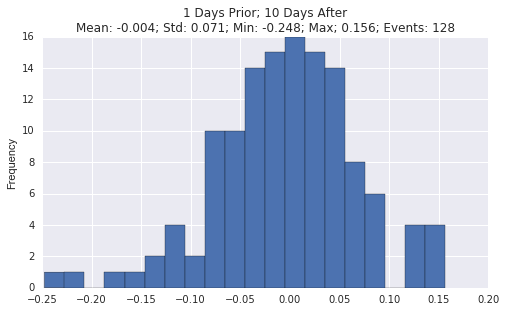

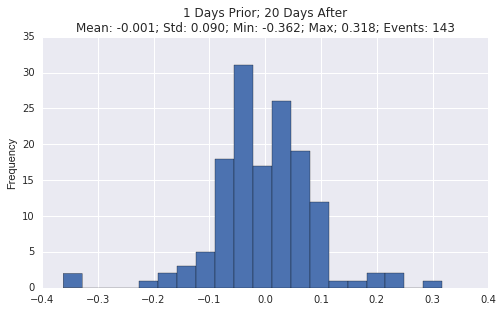

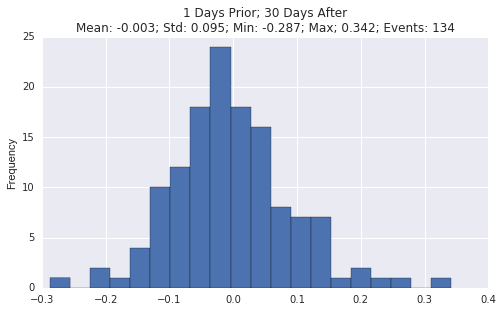

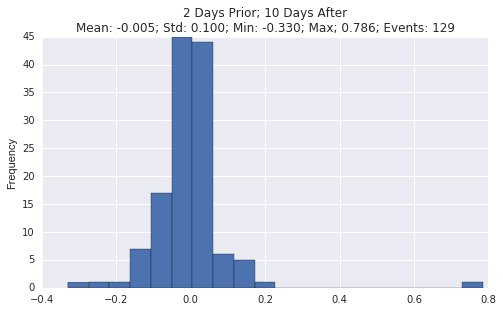

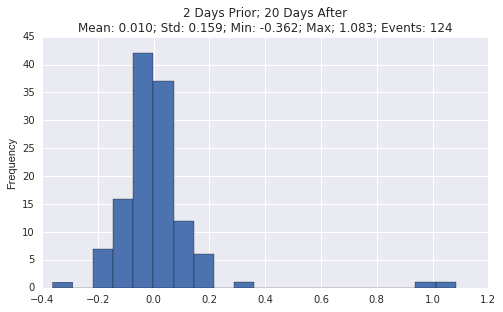

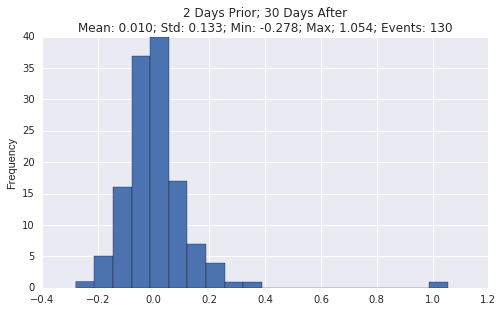

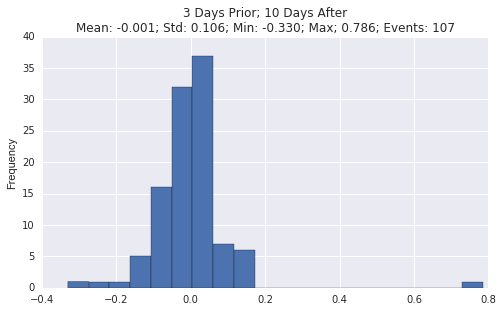

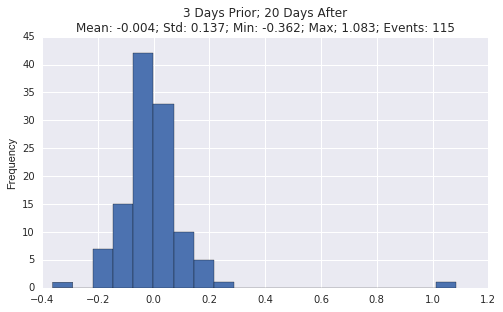

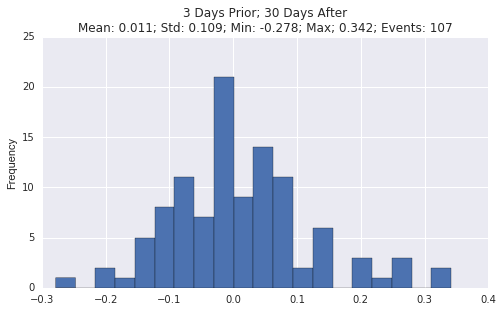

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

s1_query = open('Strategy1.sql', 'r').read()

def strategy_1(group):
    # We've already filtered out neutral surprises
    positive_surprise = group['Surprise'].values[0] > 0
    call_interest_up = (group[group['CallPut'] == 'C']
                        ['OpenInterestIncrease'].values[0]) > 0
    put_interest_up = (group[group['CallPut'] == 'P']
                       ['OpenInterestIncrease'].values[0]) > 0
    stock_increase = ((group['TradeOpenPrice'] - group['TradeClosePrice'])
                      / group['TradeClosePrice']).values[0]
    
    if positive_surprise and call_interest_up and not put_interest_up:
        return pd.DataFrame([{'stockIncrease': stock_increase}])
    elif not positive_surprise and not call_interest_up and put_interest_up:
        return pd.DataFrame([{'stockIncrease': -stock_increase}])
    else:
        return pd.DataFrame()
    
def plot_results(trade_results):
    trade_results.plot(kind='hist', bins=20)
    title = '{} Days Prior; {} Days After\n'.format(
        days_prior, days_after
    )
    title += ('Mean: {:.3f}; Std: {:.3f}; Min: {:.3f}; Max; {:.3f}; Trades: {}'
              .format(
            trade_results.mean(), trade_results.std(),
            trade_results.min(), trade_results.max(),
            len(trade_results)
        ))
    plt.title(title)
    plt.gcf().set_size_inches(8, 4.5)
    plt.show()    

for days_prior, days_after in date_settings:

    dataset = query_dataframe(s1_query.format(
            days_prior=days_prior,
            days_after=days_after
        ))

    results = dataset.groupby(['EarningsDate', 'Ticker']).apply(strategy_1)
    results = results.reset_index()
    si_results = results['stockIncrease']
    plot_results(si_results)

Let's try a small variation on this strategy: Instead of defining our trigger when call interest goes up and put interest goes down, we trigger when call interest goes up by more than put interest and vice-versa. This gives us more trades to process.

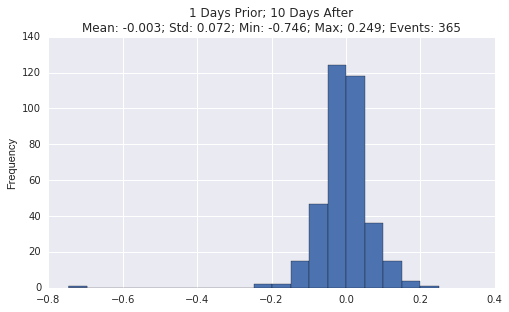

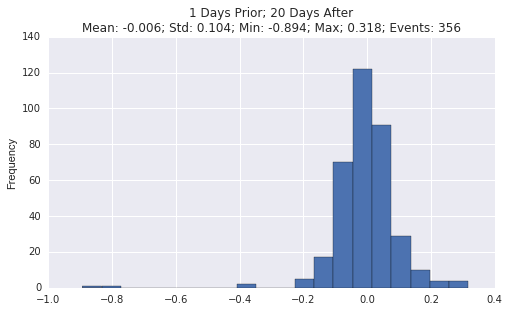

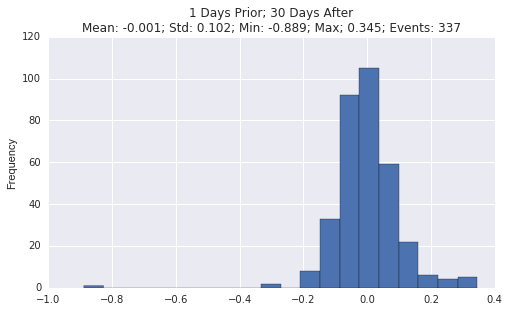

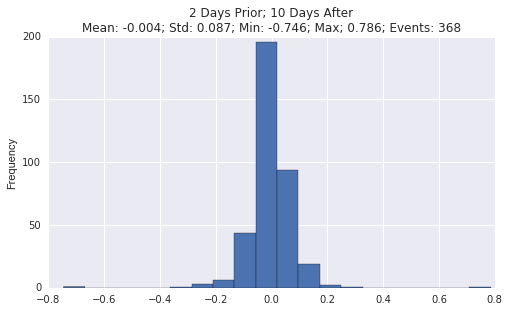

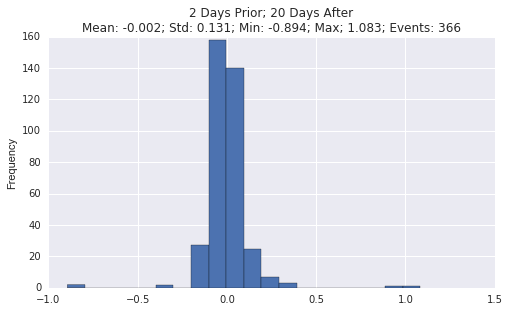

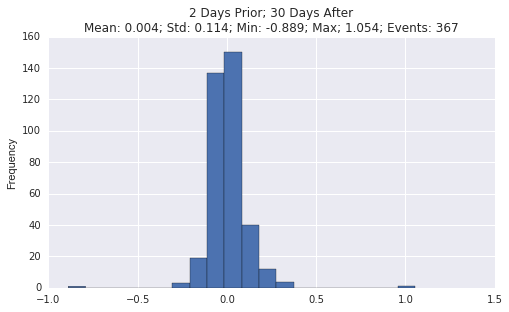

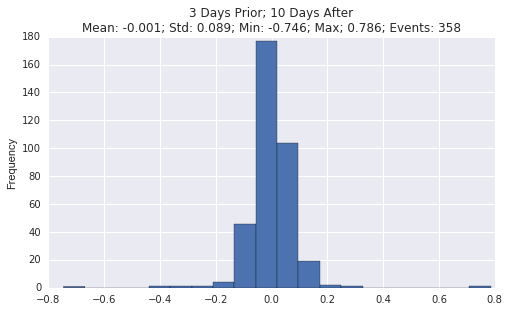

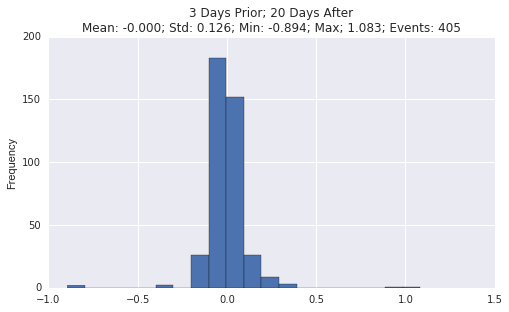

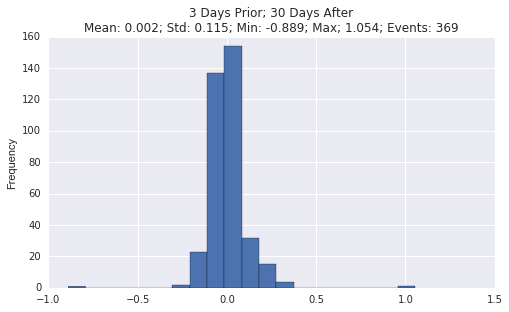

In [11]:
def strategy_1_relative(group):
    # We've already filtered out neutral surprises
    positive_surprise = group['Surprise'].values[0] > 0
    call_interest_up = (group[group['CallPut'] == 'C']
                        ['OpenInterestIncrease'].values[0])
    put_interest_up = (group[group['CallPut'] == 'P']
                       ['OpenInterestIncrease'].values[0])
    stock_increase = ((group['TradeOpenPrice'] - group['TradeClosePrice'])
                      / group['TradeClosePrice']).values[0]
    
    if positive_surprise and call_interest_up > put_interest_up:
        return pd.DataFrame([{'stockIncrease': stock_increase}])
    elif not positive_surprise and call_interest_up < put_interest_up:
        return pd.DataFrame([{'stockIncrease': -stock_increase}])
    else:
        return pd.DataFrame()
    
for days_prior, days_after in date_settings:

    dataset = query_dataframe(s1_query.format(
            days_prior=days_prior,
            days_after=days_after
        ))

    results = dataset.groupby(['EarningsDate', 'Ticker']).apply(strategy_1_relative)
    results = results.reset_index()
    si_results = results['stockIncrease']
    plot_results(si_results)

The second strategy is to essentially perform the same trade, but we are checking open interest for out of the money options instead of at-the-money options. Presumably if market participants are confident about the direction of a stock they will not buy at-the-money options; instead, they may sell at-the-money options to lever up for in-the-money options. We will check our strategy performance where we sum open interest across all out-of-the-money strikes.

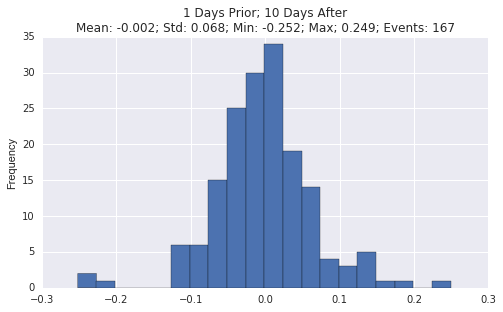

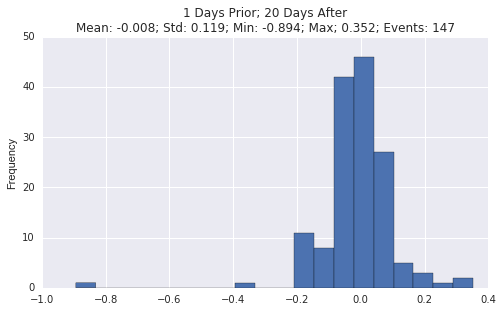

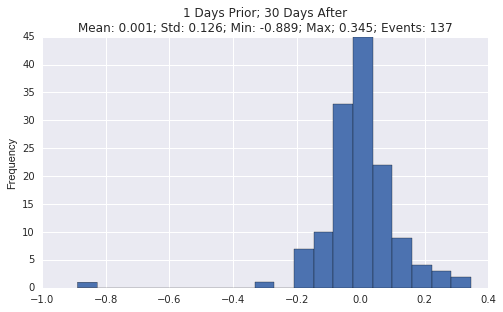

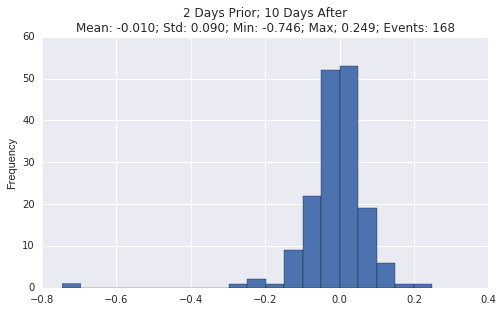

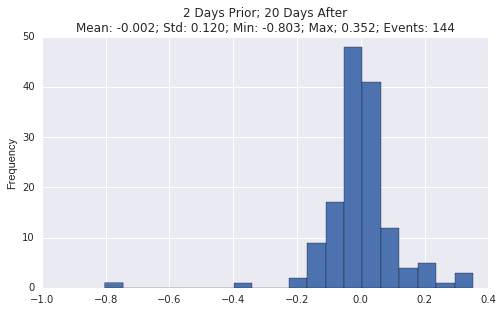

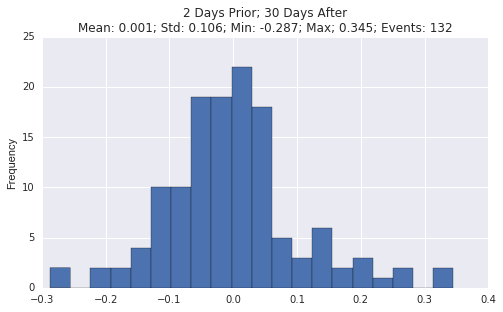

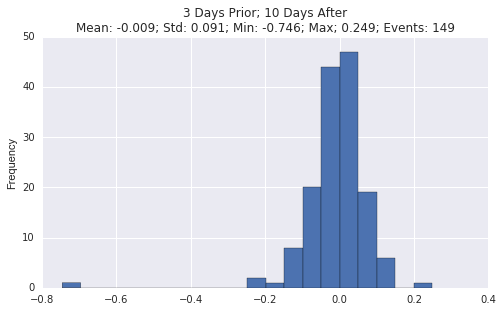

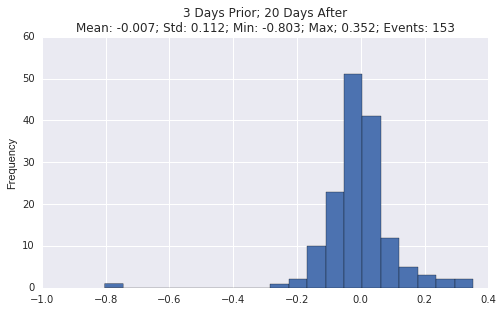

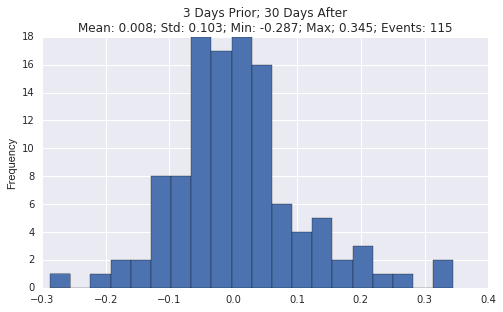

In [12]:
import pandas as pd
%matplotlib inline

s2_query = open('Strategy2.sql', 'r').read()

def strategy_2(group):
    # We've already filtered out neutral surprises
    positive_surprise = group['Surprise'].values[0] > 0
    call_interest_up = (group[group['CallPut'] == 'C']
                        ['OpenInterestIncrease'].sum()) > 0
    put_interest_up = (group[group['CallPut'] == 'P']
                       ['OpenInterestIncrease'].sum()) > 0
    stock_increase = ((group['TradeOpenPrice'] - group['TradeClosePrice'])
                      / group['TradeClosePrice']).values[0]
    
    if positive_surprise and call_interest_up and not put_interest_up:
        return pd.DataFrame([{'stockIncrease': stock_increase}])
    elif not positive_surprise and not call_interest_up and put_interest_up:
        return pd.DataFrame([{'stockIncrease': -stock_increase}])
    else:
        return pd.DataFrame()

for days_prior, days_after in date_settings:

    dataset = query_dataframe(s2_query.format(
            days_prior=days_prior,
            days_after=days_after
        ))

    results = dataset.groupby(['EarningsDate', 'Ticker']).apply(strategy_2)
    results = results.reset_index()
    si_increase = results['stockIncrease']
    plot_results(si_increase)

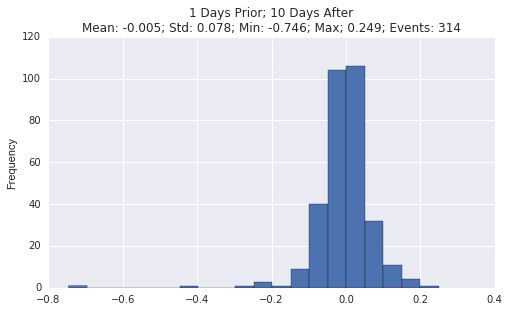

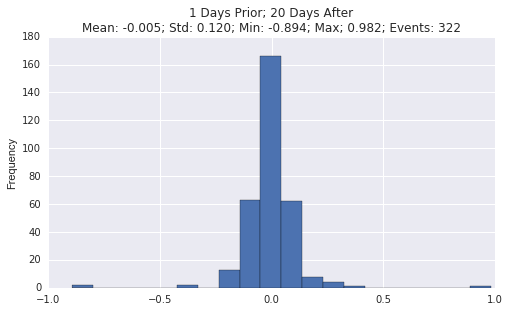

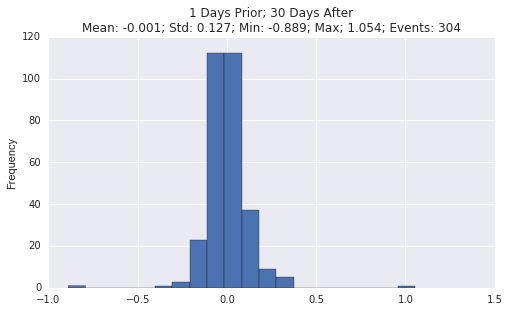

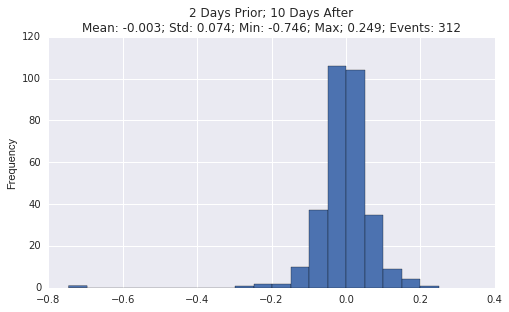

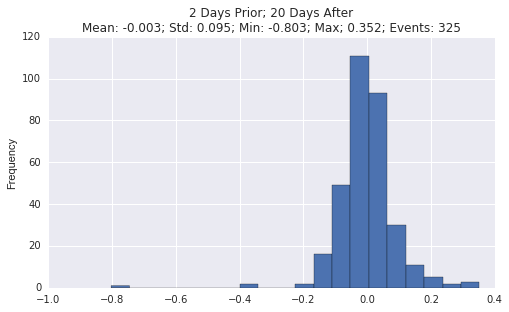

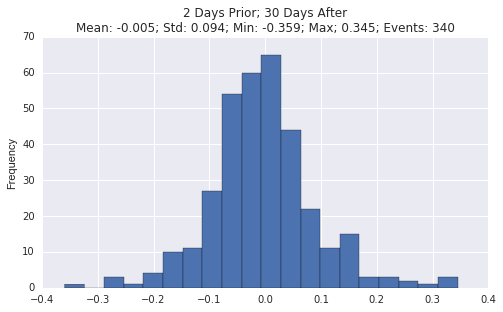

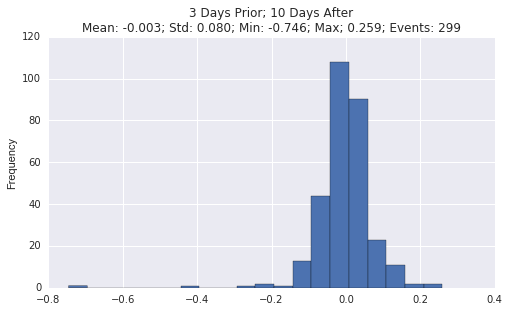

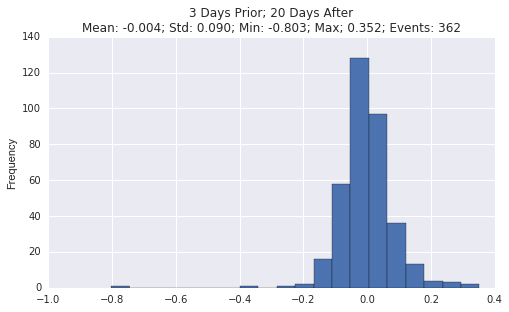

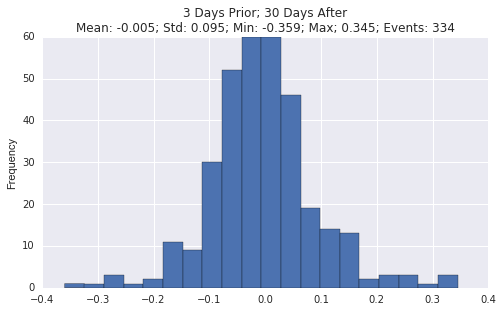

In [16]:
def strategy_2_relative(group):
    # We've already filtered out neutral surprises
    positive_surprise = group['Surprise'].values[0] > 0
    call_interest_up = (group[group['CallPut'] == 'C']
                        ['OpenInterestIncrease'].sum())
    put_interest_up = (group[group['CallPut'] == 'P']
                       ['OpenInterestIncrease'].sum())
    stock_increase = ((group['TradeOpenPrice'] - group['TradeClosePrice'])
                      / group['TradeClosePrice']).values[0]
    
    if positive_surprise and call_interest_up > put_interest_up:
        return pd.DataFrame([{'stockIncrease': stock_increase}])
    elif not positive_surprise and call_interest_up < put_interest_up:
        return pd.DataFrame([{'stockIncrease': -stock_increase}])
    else:
        return pd.DataFrame()

for days_prior, days_after in date_settings:

    dataset = query_dataframe(s2_query.format(
            days_prior=days_prior,
            days_after=days_after
        ))

    results = dataset.groupby(['EarningsDate', 'Ticker']).apply(strategy_2_relative)
    results = results.reset_index()
    si_increase = results['stockIncrease']
    plot_results(si_increase)